In [1]:
%pylab inline

# importing once and for all the needed stuff...
import gzip, os, sys, cPickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize as optimize
from scipy.stats import norm as Gaussian_PDF
from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

from matplotlib import rc
#rc('font', family = 'serif', serif = 'Times')
#rc('text', usetex = True)
from matplotlib.ticker import NullFormatter

sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in",\
    "xtick.major.size": 10, "ytick.major.size": 10,\
    "xtick.minor.size": 5,  "ytick.minor.size": 5,})

# Colors and plot-related stuff...
colori = ['#F44E21', '#28CE9A', '#1A91E2', '#585959','#BF2D19', '#A3CD39', '#39D5F1',\
        '#7F5271',  '#FF9A15', '#068C7F', '#206584', '#8CBBEA']
markers = ('o', '8', '^', '<', 'D', '*', 's', 'p', 'v', 'h', 'H', '>', 'd')

cmap_winter = matplotlib.cm.winter
cmap_autumn = matplotlib.cm.autumn
cmap_summer = matplotlib.cm.summer
cmap_spring = matplotlib.cm.spring
cmap_rb = matplotlib.cm.rainbow

Populating the interactive namespace from numpy and matplotlib


## Loading data...

First define the datafile to use as *dat_file_name*...

In [2]:
dat_file_name = {
        "TWT": "/home/ubi/owncloud/PhD/TVN/Urne/out/data-01-09_company_like/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz",
        "MPC": "/home/ubi/owncloud/PhD/TVN/Urne/out/MPC/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz",
        "APS": "/home/ubi/owncloud/PhD/TVN/Urne/out/aff_data_ISI_company_like_1970_2006/data/networkStats_a130_k130_e130_stBySt0_tScheve_bSchek.dat.gz",
        "APS_samples": "/home/ubi/owncloud/PhD/TVN/Urne/out/APS_subsamples/sample_00/data/networkStats_a130_k130_e130_stBySt0_tScheve_bSchek.dat.gz",
        #"URNS_TWT": "/home/ubi/urns_serie/out/Symm_SonsExchg0_StrctSmpl1_r05_n05_t000001000000_Run_03/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz",
        "URNS_TWT": "/home/ubi/urns_serie/out/Symm_SonsExchg0_StrctSmpl1_r05_n05_t000001000000_Run_03/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz",
        "URNS_MPC": "/home/ubi/urns_serie/out/Symm_SonsExchg1_StrctSmpl1_r21_n07_t000050000000_Run_00/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz",
        "URNS_APS": "/home/ubi/urns_serie/out/Symm_SonsExchg1_StrctSmpl2_r06_n15_t000000500000_Run_00/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz",
    }

DATA = {k: cPickle.load(gzip.open(v, 'rb')) for k, v in dat_file_name.items()}

## $F(a)$ and $F(k)$

In [3]:
from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)
    
def plotFak(ax, empirical, synthetic, color=0, what="a", label="***", yscale=(1., 1.), plotFit=False):
    what = "Act" if what == "a" else "Deg"
    markers = "o<^s>"
    minx, maxx = 1e8, -1e8
    for iii, DATA in enumerate([empirical, synthetic]):
        
        f, b = np.histogram(DATA["Arrays"][what], bins=Lin_Log_Bins(1, 50000, factor=1.5), density=True)
        
        b = (b[:-1] + b[1:])/2.
        b = b[f>0]
        f = f[f>0]
        ax.loglog(b, f*yscale[iii],
                    marker=markers[color%len(markers)] if iii==0 else "", linestyle="-" if iii==1 else "",
                    ms=8, c="C%d" % color if iii==0 else "C%d" % color, label=label if iii==0 else "",
                    lw=3.15, mec="C%d" % color, mew=2)

        b_XXX = np.logspace(np.log10(min(min(b), min(b)))*.95,
                            np.log10(max(max(b), max(b)))*1.05, 20)
        
        if plotFit and iii == 1:
            res_nu, cov_nu = curve_fit(powLaw, b, f,
                                   p0=[1., -1.], sigma=1./b**2.5,
                                   bounds=((1e-8, -3.1), (1e8, 3.1)))
            
            ax.loglog(b_XXX, powLaw(b_XXX, *res_nu)*yscale[iii], "-C2", lw=2,
                   label=r"$F(a) \propto a^{-%.02f}$" % res_nu[1])

        ax.set_xlim(b_XXX[0], b_XXX[-1])
        minx, maxx = min(minx, b_XXX[0]), max(maxx, b_XXX[-1])
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.set_xlabel(r"Activity $a$" if what == "Act" else r"Degree $k$", size=20)
        ax.set_ylabel(r"$F(a)$ [a.u.]" if what == "Act" else r"$F(k)$ [a.u.]", size=20)
    return (minx, maxx)

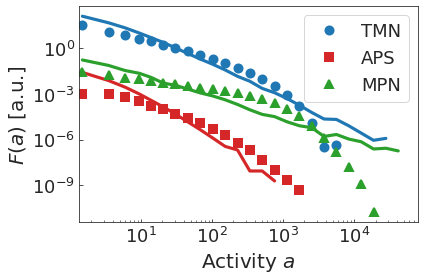

In [4]:
fig, ax = plt.subplots(1,1)
v1 = plotFak(ax, DATA["TWT"], DATA["URNS_TWT"], what="a", label="TMN", yscale=(200, 500), color=0)
v2 = plotFak(ax, DATA["APS"], DATA["URNS_APS"], what="a", label="APS", yscale=(1e-2, 8e-2), color=3)
v3 = plotFak(ax, DATA["MPC"], DATA["URNS_MPC"], what="a", label="MPN", yscale=(1e0, 1e0), color=2)

plt.xlim(min([t[0] for t in [v1,v2,v3]])*.9, max([t[1] for t in [v1,v2,v3]])*1.1)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("ALL_F_a.pdf", bbox_inces="tight")

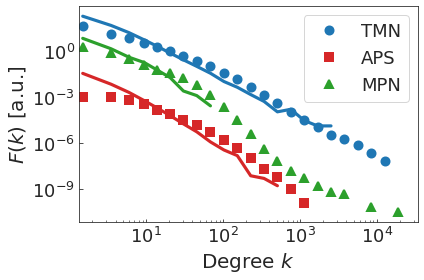

In [5]:
fig, ax = plt.subplots(1,1)
v1 = plotFak(ax, DATA["TWT"], DATA["URNS_TWT"], what="k", label="TMN", yscale=(200, 600), color=0)
v2 = plotFak(ax, DATA["APS"], DATA["URNS_APS"], what="k", label="APS", yscale=(1e-2, 1e-1), color=3)
v3 = plotFak(ax, DATA["MPC"], DATA["URNS_MPC"], what="k", label="MPN", yscale=(8e0, 2e1), color=2)

plt.xlim(min([t[0] for t in [v1,v2,v3]])*.9, max([t[1] for t in [v1,v2,v3]])*1.1)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("ALL_F_k.pdf", bbox_inces="tight")

## $A(t)$ and $D(t)$

In [6]:
def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

def plot_A_D_t(ax, empirical, synthetic, color=0, what="a", label="***", yscale=(1., 1.), plotFit=False):
    what = "EdgesActiveT" if what == "a" else "NodesActiveT"
    markers = "o<^s>"
    minx, maxx = 1e8, -1e8
    for iii, DATA in enumerate([empirical, synthetic]):
        timeDates = np.array(DATA["TimeVecs"]["EventsT"])
        XXXs = timeDates[::2]/float(timeDates[0])
        YYYs = np.array(DATA["TimeVecs"][what])[::2]
        YYYs =  YYYs * yscale[iii] / float(YYYs[0])
        ax.loglog(XXXs, YYYs,
                    marker=markers[color%len(markers)] if iii==0 else "", linestyle="-" if iii==1 else "",
                    ms=8, c="C%d" % color if iii==0 else "C%d" % color, label=label if iii==0 else "",
                    lw=3.15, mec="C%d" % color, mew=2)
        
        if plotFit and iii == 1:
            SSSs = 1./XXXs**.75
            res_Ne, chi_Ne = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))
            ax.loglog(XXXs, Power_Growth_foo(XXXs, *res_Ne)*yscale[iii], "-C2", lw=2)

        ax.set_xlim(XXXs[0], XXXs[-1])
        minx, maxx = min(minx, XXXs[0]), max(maxx, XXXs[-1])
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.set_xlabel(r"$t$ [events - rescaled]", size=20)
        ax.set_ylabel(r"$A(t)$ [rescaled]" if what == "EdgesActiveT" else r"$D(t)$ [rescaled]", size=20)
    return (minx, maxx)

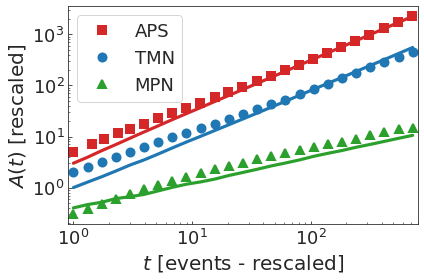

In [7]:
fig, ax = plt.subplots(1,1)
v2 = plot_A_D_t(ax, DATA["APS"], DATA["URNS_APS"], what="a", label="APS", yscale=(5e0, 3e0), color=3)
v1 = plot_A_D_t(ax, DATA["TWT"], DATA["URNS_TWT"], what="a", label="TMN", yscale=(2e0, 1e0), color=0)
v3 = plot_A_D_t(ax, DATA["MPC"], DATA["URNS_MPC"], what="a", label="MPN", yscale=(3e-1, 4e-1), color=2)

plt.xlim(min([t[0] for t in [v1,v2,v3]])*.9, max([t[1] for t in [v1,v2,v3]])*1.1)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("ALL_At.pdf", bbox_inces="tight")

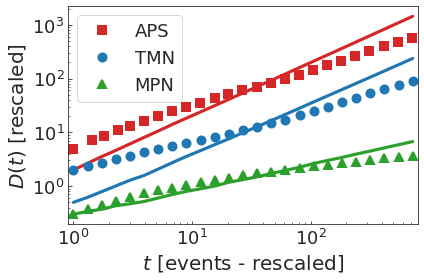

In [8]:
fig, ax = plt.subplots(1,1)
v2 = plot_A_D_t(ax, DATA["APS"], DATA["URNS_APS"], what="d", label="APS", yscale=(5e0, 2e0), color=3)
v1 = plot_A_D_t(ax, DATA["TWT"], DATA["URNS_TWT"], what="d", label="TMN", yscale=(2e0, .5e0), color=0)
v3 = plot_A_D_t(ax, DATA["MPC"], DATA["URNS_MPC"], what="d", label="MPN", yscale=(3e-1, 3e-1), color=2)

plt.xlim(min([t[0] for t in [v1,v2,v3]])*.9, max([t[1] for t in [v1,v2,v3]])*1.1)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("ALL_Dt.pdf", bbox_inces="tight")

## $P(c_i)$

In [41]:
pnk_file_name = {
        "TWT": "/home/ubi/owncloud/PhD/TVN/Urne/out/data-01-09_company_like/data/pn_data_out_bSchek.pkl",
        "MPC": "/home/ubi/owncloud/PhD/TVN/Urne/out/MPC/data/pn_data_out_bSchek.pkl",
        "APS": "/home/ubi/owncloud/PhD/TVN/Urne/out/aff_data_ISI_company_like_1970_2006/data/pn_data_out_bSchek.pkl",
        "APS_samples": "/home/ubi/owncloud/PhD/TVN/Urne/out/APS_subsamples/sample_00/data/pn_data_out_bSchek.pkl",
        "URNS_TWT": "/home/ubi/urns_serie/out/Symm_SonsExchg0_StrctSmpl1_r05_n05_t000001000000_Run_03/data/pn_data_out_bSchek.pkl",
        "URNS_MPC": "/home/ubi/urns_serie/out/Symm_SonsExchg1_StrctSmpl1_r21_n07_t000050000000_Run_00/data/pn_data_out_bSchek.pkl",
        "URNS_APS": "/home/ubi/urns_serie/out/Symm_SonsExchg1_StrctSmpl2_r06_n15_t000000500000_Run_00/data/pn_data_out_bSchek.pkl",
    }

DATA_PNK = {k: cPickle.load(open(v, 'rb')) for k, v in pnk_file_name.items()}

In [42]:
DATA_PNK["TWT"].keys()

['Beta_int',
 'Tot_Chi_Sums',
 'Ind_Bopt',
 'Chi_Sums',
 'Fixed_Beta',
 'Pn_Curves',
 'Beta_Opt',
 'opt_params',
 'binningScheme',
 'opt_pars',
 'BASE_DIR']

In [43]:
def plot_Pci(ax, empirical, empiricalD, synthetic, syntheticD, selectedSuperClasses,
             label="***", yscale=(1., 1.), n_points_Pc=12, Fixed_Beta=True, const_bounds=(1e-5, 1e2)):
    currentSuperClass = lambda classID: classID[:1]
    markers = "os"
    minx, maxx = 1e8, -1e8
    
    for iii, (DATA, DATADATA) in enumerate([(empirical, empiricalD), (synthetic, syntheticD)]):
        Beta_Opt = DATA["Beta_Opt"]
        Pn_Curves = DATA["Pn_Curves"]
        opt_pars = DATA["opt_pars"]
        
        # The containers for the cumulative (overall) distribution of P(c)...
        TOT_cs = []
        TOT_ns = []

        for superClass in selectedSuperClasses:
            validClasses = [classId for classId in Pn_Curves.keys() if currentSuperClass(classId) == superClass]
            if not validClasses:
                continue
            for nodeClass in validClasses:
                optBetaValue = Beta_Opt if Fixed_Beta else np.argmin([Chi_Sums[b][nodeClass] for b in Beta_int])
                TOT_cs.append(opt_pars[optBetaValue][nodeClass][1])
                TOT_ns.append(DATADATA["Bins"]["N_A_K"][nodeClass])

        # Then plotting the overall distribution...
        YY, XX = np.histogram(TOT_cs, weights=TOT_ns, density=True,
                              bins=np.logspace(np.log10(max(const_bounds[0],min(TOT_cs))),
                                               np.log10(min(const_bounds[1],max(TOT_cs))), n_points_Pc))
        XX = (XX[1:] + XX[:-1])/2.
        XX = XX[YY>.0]
        YY = YY[YY>.0]
        ax.loglog(XX, YY, '-' + markers[iii], ms=8, lw=4,
                   color='C%d'%iii, label=label if iii==0 else "Model")

    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.set_xlabel(r"$c_i$", size=20)
    ax.set_ylabel(r"$P(c_i)$ [rescaled]", size=20)

In [44]:
def plot_PciBox(ax, empirical, empiricalD, synthetic, syntheticD, selectedSuperClasses,
            color=0,
             label="***", yscale=(1., 1.), n_points_Pc=12, Fixed_Beta=True, const_bounds=(1e-5, 1e2), positions=(0,1)):
    currentSuperClass = lambda classID: classID[:1]
    markers = "os"
    minx, maxx = 1e8, -1e8
    
    dati = []
    for iii, (DATA, DATADATA) in enumerate([(empirical, empiricalD), (synthetic, syntheticD)]):
        Beta_Opt = DATA["Beta_Opt"]
        Beta_int = DATA["Beta_int"]
        Chi_Sums = DATA["Chi_Sums"]
        Pn_Curves = DATA["Pn_Curves"]
        opt_pars = DATA["opt_pars"]
        
        # The containers for the cumulative (overall) distribution of P(c)...
        TOT_cs = []
        TOT_ns = []

        for superClass in selectedSuperClasses:
            validClasses = [classId for classId in Pn_Curves.keys() if currentSuperClass(classId) == superClass]
            if not validClasses:
                continue
            for nodeClass in validClasses:
                optBetaValue = Beta_Opt if Fixed_Beta else np.argmin([Chi_Sums[b][nodeClass] for b in Beta_int])
                tmp_num = DATADATA["Bins"]["N_A_K"][nodeClass]
                tmp_const = opt_pars[optBetaValue][nodeClass][1]
                if tmp_const >= 1e-2:
                    TOT_cs.extend([tmp_const]*tmp_num)
                    TOT_ns.append(tmp_num)

        # Then plotting the overall distribution...
        #YY, XX = np.histogram(TOT_cs, weights=TOT_ns, density=True,
        #                      bins=np.logspace(np.log10(max(const_bounds[0],min(TOT_cs))),
        #                                       np.log10(min(const_bounds[1],max(TOT_cs))), n_points_Pc))
        #XX = (XX[1:] + XX[:-1])/2.
        #XX = XX[YY>.0]
        #YY = YY[YY>.0]
        #ax.loglog(XX, YY, '-' + markers[iii], ms=8, lw=4,
        #           color='C%d'%iii, label=label if iii==0 else "Model")
        dati.append(TOT_cs)
    boxprops = dict(linestyle='-', linewidth=3, color='C%d'%color)
    whiprops = dict(linestyle='--', linewidth=2, color='k')
    ax.boxplot(dati, labels=[label, "Model"], positions=positions,
               boxprops=boxprops, whiskerprops=whiprops, widths=.25, whis="range")

    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    #ax.set_xlabel(r"$c_i$", size=20)
    ax.set_ylabel(r"$P(c_i)$", size=20)

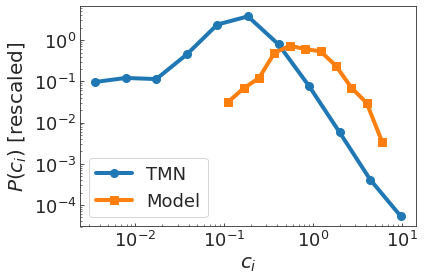

In [53]:
who, label = "TWT", "TMN"

selectedSuperClasses = [(i,) for i in range(4, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pci(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pci_%s.pdf" % who, bbox_inces="tight")

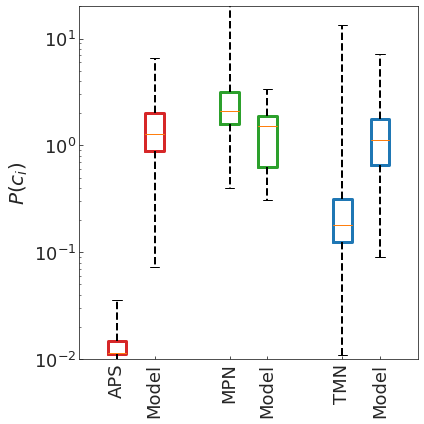

In [11]:
who, label = "APS", "APS"
selectedSuperClasses = [(i,) for i in range(4, 200, 1)]
fig, ax = plt.subplots(1,1,figsize=(6,6))
plot_PciBox(ax, DATA_PNK[who+"_samples"], DATA[who+"_samples"], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label, positions=[0,.5], color=3)

who, label = "MPC", "MPN"
selectedSuperClasses = [(i,) for i in range(4, 200, 1)]
plot_PciBox(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label, positions=[1.5,2.], color=2)


who, label = "TWT", "TMN"
selectedSuperClasses = [(i,) for i in range(4, 200, 1)]
plot_PciBox(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label, positions=[3.,3.5], color=0)

plt.yscale("log")

plt.xticks([0,.5, 1.5,2., 3,3.5],
           ["APS", "Model", "MPN", "Model", "TMN", "Model"], rotation=90, ha="center")

plt.xlim(-.5,4.)
plt.ylim(1e-2, 20)
#plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pci_BOX_ALL.pdf", bbox_inces="tight")

In [45]:
print("READY")

READY


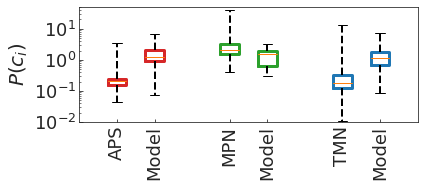

In [50]:
who, label = "APS", "APS"
selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1,figsize=(6,2.7))
plot_PciBox(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label, positions=[0,.5], color=3)

who, label = "MPC", "MPN"
selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
plot_PciBox(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label, positions=[1.5,2.], color=2)


who, label = "TWT", "TMN"
selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
plot_PciBox(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label, positions=[3.,3.5], color=0)

plt.yscale("log")

plt.xticks([0,.5, 1.5,2., 3,3.5],
           ["APS", "Model", "MPN", "Model", "TMN", "Model"], rotation=90, ha="center")

plt.xlim(-.5,4.)
plt.ylim(1e-2, 50)
#plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pci_BOX_ALL_inset.pdf", bbox_inces="tight")

In [352]:
fig.get_size_inches()

array([6., 4.])

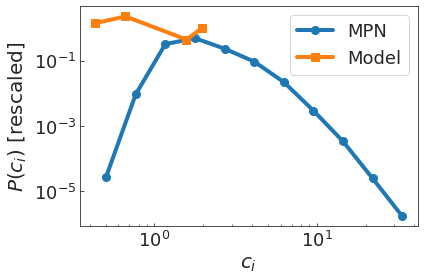

In [54]:
who, label = "MPC", "MPN"

selectedSuperClasses = [(i,) for i in range(0, 400, 1)]
fig, ax = plt.subplots(1,1)
plot_Pci(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pci_%s.pdf" % who, bbox_inces="tight")

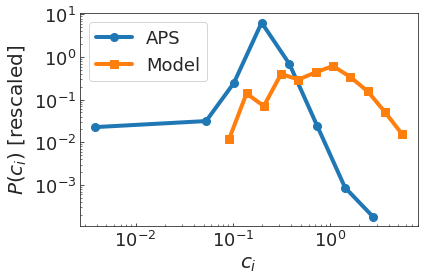

In [55]:
who, label = "APS", "APS"

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pci(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         selectedSuperClasses, label=label)

plt.legend(fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pci_%s.pdf" % who, bbox_inces="tight")

## Overlapping $p(k)$ curves

In [12]:
#DATA["TWT"]["Bins"]["N_A_K"].values()

In [13]:
print("READY remmeber to check figure P(c_i)")

READY remmeber to check figure P(c_i)


In [14]:
from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

def plot_Pki(ax, empirical, empiricalD, synthetic, syntheticD, factor=3., alphascale=500,
             Sel_acts=(range(0,150,1), range(0,150,1)), singlePlotEvery=(2,2),
             label="***", yscale=(1., 1.), n_points_Pc=12, Fixed_Beta=True, const_bounds=(1e-5, 1e2)):

    markers = "os"
    markers = 'o8^<D*spvhH>d'
    minX, maxX = 1e6, -1e6
    for iii, (DATA, DATADATA) in enumerate([(empirical, empiricalD), (synthetic, syntheticD)]):
        Beta_Opt = DATA["Beta_Opt"]
        Pn_Curves = DATA["Pn_Curves"]
        opt_pars = DATA["opt_pars"]
        
        maxPop = float(max(DATADATA["Bins"]["N_A_K"].values()))
        
        # The containers for the cumulative (overall) distribution of P(c)...
        TOT_xxxs = []
        TOT_yyys = []
        
        resc_lim = [1000, .01]

        aindex = 0
        ak = 0
        for class_tuple, class_dict in sorted(Pn_Curves.items()):
            if aindex in Sel_acts[iii] and ak % singlePlotEvery[iii] == 0:
                tmp_pars = opt_pars[Beta_Opt][class_tuple]
                tmp_pop = DATADATA["Bins"]["N_A_K"][class_tuple]
                XXXs = class_dict['x_smooth']/tmp_pars[1]
                YYYs = class_dict['y_smooth']**(1./tmp_pars[0])
                if iii == 0:
                    serie_tmp, = ax.loglog(XXXs, YYYs,
                               linestyle='--', marker=markers[ak%len(markers)], ms=8, alpha=tmp_pop/maxPop*alphascale)
                elif iii == 1:
                    TOT_xxxs.extend(XXXs)
                    TOT_yyys.extend(YYYs)
                minX, maxX = min(minX, min(XXXs)), max(maxX, max(XXXs))
            ak += 1
            aindex += 1


        if iii == 1:
            X = np.logspace(np.floor(np.log10(minX)), np.ceil(np.log10(maxX)), 30)
            ax.loglog(X, p_n_pow_const([1, 1], X), "-k", lw=3, alpha=.7, label=r"$(1+x)^{-1}$")
            
            X, Y = Smooth_Curve(TOT_xxxs, TOT_yyys, factor=factor)
            empirical = ax.loglog(X, Y, "-C3", lw=4, ms=8, alpha=1, label="Model")
            
    ax.set_xscale("log")   
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.set_xlabel(r"$x = k/c_i$", size=20)
    ax.set_ylabel(r"$p(x)^{1/\beta}$", size=20)
    return serie_tmp

In [23]:
from my_foos import Lin_Log_Bins, Smooth_Curve, p_n_pow_const, Power_Growth

def plot_Pki(ax, empirical, empiricalD, synthetic, syntheticD, factor=3., alphascale=500,
             Sel_acts=(range(0,150,1), range(0,150,1)), singlePlotEvery=(2,2),
             label="***", yscale=(1., 1.), n_points_Pc=12, Fixed_Beta=True, const_bounds=(1e-5, 1e2),
             explode=[True,False], withGuideline=True,
            ):

    markers = "os"
    markers = 'o8^<D*spvhH>d'
    minX, maxX = 1e6, -1e6
    for iii, (DATA, DATADATA) in enumerate([(empirical, empiricalD), (synthetic, syntheticD)]):
        Beta_Opt = DATA["Beta_Opt"]
        Pn_Curves = DATA["Pn_Curves"]
        opt_pars = DATA["opt_pars"]
        
        maxPop = float(max(DATADATA["Bins"]["N_A_K"].values()))
        
        # The containers for the cumulative (overall) distribution of P(c)...
        TOT_xxxs = []
        TOT_yyys = []
        
        resc_lim = [1000, .01]

        aindex = 0
        ak = 0
        for class_tuple, class_dict in sorted(Pn_Curves.items()):
            if aindex in Sel_acts[iii] and ak % singlePlotEvery[iii] == 0:
                tmp_pars = opt_pars[Beta_Opt][class_tuple]
                tmp_pop = DATADATA["Bins"]["N_A_K"][class_tuple]
                XXXs = class_dict['x_smooth']/tmp_pars[1]
                YYYs = class_dict['y_smooth']**(1./tmp_pars[0])
                if explode[iii]:
                    if iii == 0:
                        serie_tmp, = ax.loglog(XXXs, YYYs,
                                   linestyle='--', marker=markers[ak%len(markers)],
                                   ms=8, alpha=tmp_pop/maxPop*alphascale)
                    else:
                        serie_tmp, = ax.loglog(XXXs, YYYs,
                                linestyle='-', marker=markers[ak%len(markers)],
                                ms=8, color=(0,0,0,.3), lw=.5,
                                #alpha=tmp_pop/maxPop*alphascale,
                                fillstyle='none', markeredgecolor=(0,0,0,.4))
                else:
                    TOT_xxxs.extend(XXXs)
                    TOT_yyys.extend(YYYs)
                minX, maxX = min(minX, min(XXXs)), max(maxX, max(XXXs))
            ak += 1
            aindex += 1
            
        if not explode[iii]:
            X, Y = Smooth_Curve(TOT_xxxs, TOT_yyys, factor=factor)
            empirical = ax.loglog(X, Y, "-C%d" % (iii), lw=6, ms=8, alpha=1, label=label if iii == 0 else "Model")
            
        if iii == 1 and withGuideline:
            X = np.logspace(np.floor(np.log10(minX)), np.ceil(np.log10(maxX)), 30)
            ax.loglog(X, p_n_pow_const([1, 1], X), "-k", lw=3, alpha=.7, label=r"$(1+x)^{-1}$")
            
    ax.set_xscale("log")   
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.set_xlabel(r"$x = k/c_i$", size=20)
    ax.set_ylabel(r"$p(x)^{1/\beta}$", size=20)

In [24]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

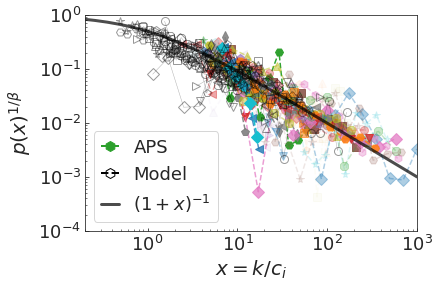

In [25]:
who, label = "APS", "APS"
explode = [True, True]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(30, 160, 3), range(0, 500, 4)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()

plt.xlim(2e-1, 1e3)
plt.ylim(1e-4,1)

plt.savefig("Pki_%s_panel.pdf" % who, bbox_inces="tight")

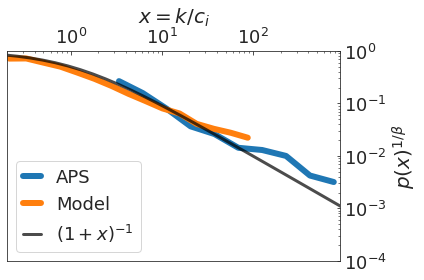

In [26]:
who, label = "APS", "APS"
explode = [False, False]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(18, 210, 3), range(10, 500, 1)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()

#plt.xlim(2e-1, 5e2)
plt.xlim(2e-1, 9e2)
plt.ylim(1e-4,1)

plt.tight_layout()
plt.savefig("Pki_%s_inset.pdf" % who, bbox_inces="tight")

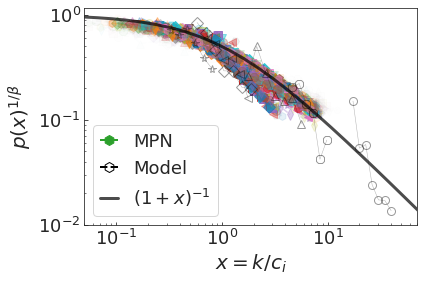

In [27]:
who, label = "MPC", "MPN"
explode = [True, True]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(100, 1600, 2), range(0, 10500, 1)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()

plt.xlim(5e-2, 7e1)
plt.ylim(1e-2,1.15)

plt.savefig("Pki_%s_panel.pdf" % who, bbox_inces="tight")

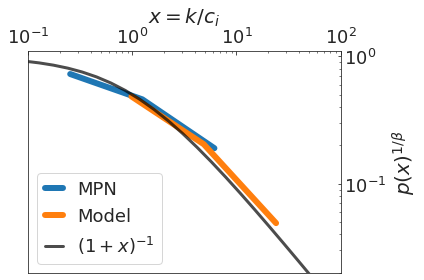

In [28]:
who, label = "MPC", "MPN"
explode = [False, False]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(18, 210, 3), range(0, 10500, 1)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()

#plt.xlim(2e-1, 5e2)
plt.xlim(1e-1, 1e2)
plt.ylim(2e-2,1.1)

plt.tight_layout()
plt.savefig("Pki_%s_inset.pdf" % who, bbox_inces="tight")

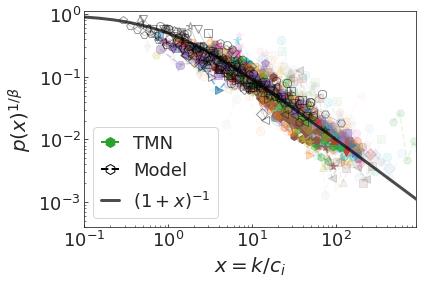

In [40]:
who, label = "TWT", "TMN"
explode = [True, True]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(0, 1600, 3), range(10, 10500, 4)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()

plt.xlim(1e-1, 9e2)
plt.ylim(4e-4,1.15)

plt.savefig("Pki_%s_panel.pdf" % who, bbox_inces="tight")

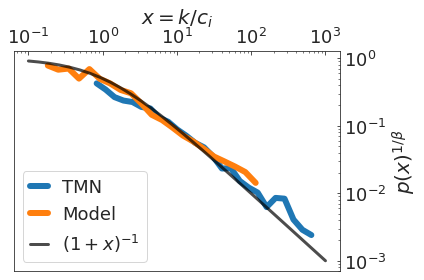

In [38]:
who, label = "TWT", "TMN"
explode = [False, False]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(30, 2100, 4), range(0, 10500, 4)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

ax.yaxis.set_ticks_position("right")
ax.yaxis.set_label_position("right")

ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()

#plt.xlim(2e-1, 5e2)
# plt.xlim(1e-1, 1e2)
# plt.ylim(2e-2,1.1)

plt.tight_layout()
plt.savefig("Pki_%s_inset.pdf" % who, bbox_inces="tight")

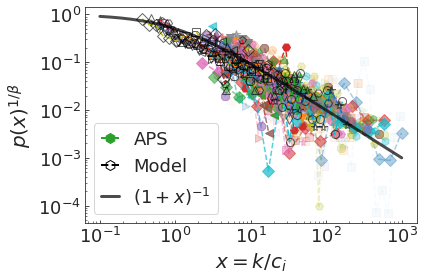

In [125]:
who, label = "MPC", "MPN"
explode = [True, True]
withGuideline = True

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(30, 260, 2), range(0, 100, 5)), label=label,
        explode=explode, withGuideline=withGuideline,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", fillstyle='none',  color="k",  linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()
#plt.savefig("Pki_%s.pdf" % who, bbox_inces="tight")

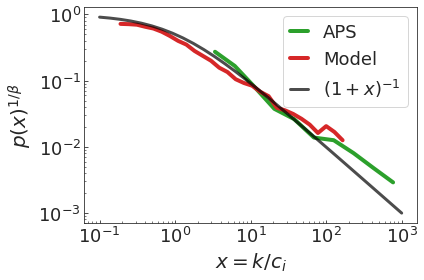

In [76]:
who, label = "APS", "APS"
explode = [False, False]

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(30, 260, 3), range(0, 100, 1)), label=label,
        explode=explode,
    )

leg = plt.legend(fontsize=18, loc="best")
#line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)
line = Line2D([0], [0], marker="h", color="C2", linestyle="--", lw=2, ms=10, label=label)
lineMod = Line2D([0], [0], marker="h", color="C3", linestyle="--", lw=2, ms=10, label="Model")

handles = []
if explode[0]:
    handles += [line]
if explode[1]:
    handles += [lineMod]

handles += leg.get_lines()

plt.legend(handles=handles, handlelength=1., handletextpad=.8, fontsize=18, loc="best")
plt.tight_layout()
#plt.savefig("Pki_%s.pdf" % who, bbox_inces="tight")

In [77]:
l = handles[2]
l.get_label()

u'$(1+x)^{-1}$'

In [73]:
leg.get_lines()

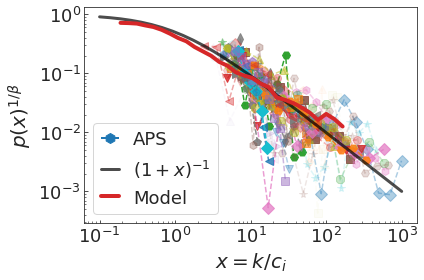

In [28]:
who, label = "APS", "APS"

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
serie_tmp = plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(30, 260, 3), range(0, 100, 1)), label=label)

leg = plt.legend(fontsize=18, loc="best")
line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)

plt.legend(handles=[line] + leg.get_lines(),
           handlelength=1., handletextpad=.8,
           fontsize=18, loc="best")
plt.tight_layout()
#plt.savefig("Pki_%s.pdf" % who, bbox_inces="tight")

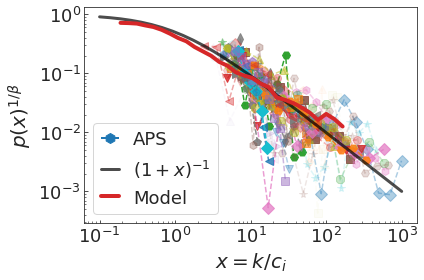

In [314]:
who, label = "APS", "APS"

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
serie_tmp = plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=40., alphascale=380,
         singlePlotEvery=(1,1), Sel_acts=(range(30, 260, 3), range(0, 100, 1)), label=label)

leg = plt.legend(fontsize=18, loc="best")
line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)

plt.legend(handles=[line] + leg.get_lines(),
           handlelength=1., handletextpad=.8,
           fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pki_%s.pdf" % who, bbox_inces="tight")

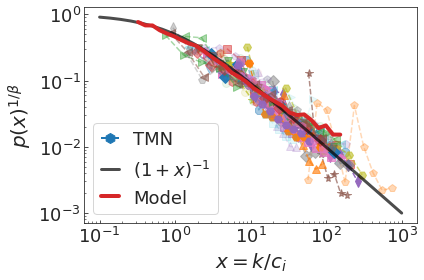

In [315]:
who, label = "TWT", "TMN"

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=20., alphascale=750,
         singlePlotEvery=(2,1), Sel_acts=(range(40, 260, 6), range(0, 100, 1)), label=label)

leg = plt.legend(fontsize=18, loc="best")
line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)

plt.legend(handles=[line] + leg.get_lines(),
           handlelength=1., handletextpad=.8,
           fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pki_%s.pdf" % who, bbox_inces="tight")

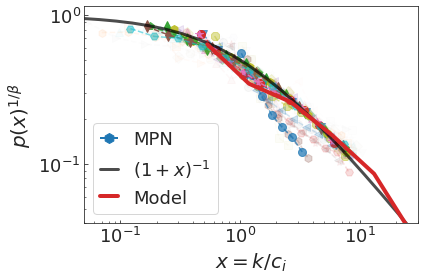

In [316]:
who, label = "MPC", "MPN"

selectedSuperClasses = [(i,) for i in range(0, 200, 1)]
fig, ax = plt.subplots(1,1)
plot_Pki(ax, DATA_PNK[who], DATA[who], DATA_PNK["URNS_%s"%who], DATA["URNS_%s"%who],
         factor=20., alphascale=900,
         singlePlotEvery=(2,1), Sel_acts=(range(10, 260, 6), range(0, 100, 1)), label=label)

plt.xlim(5e-2, 3e1)
plt.ylim(4e-2, 1.15e0)

leg = plt.legend(fontsize=18, loc="best")
line = Line2D([0], [0], marker="h", color="C0", linestyle="--", lw=2, ms=10, label=label)

plt.legend(handles=[line] + leg.get_lines(),
           handlelength=1., handletextpad=.8,
           fontsize=18, loc="best")
plt.tight_layout()
plt.savefig("Pki_%s.pdf" % who, bbox_inces="tight")

In [75]:
x, y = Smooth_Curve(range(1, 100), range(101,200), binning="log", factor=3.)

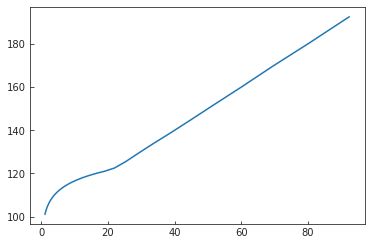

In [76]:
plt.plot(x,y)

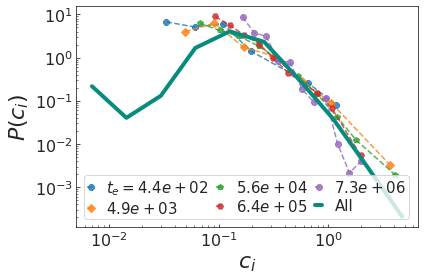

In [76]:
##################################################
# Now plotting the distribution of the optimized #
# constant for each activity class...            #
##################################################
n_points_Pc = 12

fig_Pconst = plt.figure()

# The containers for the cumulative (overall) distribution of P(c)...
TOT_cs = []
TOT_ns = []

firstPlot = True
for superClass in selectedSuperClasses:
    validClasses = [classId for classId in Pn_Curves.keys() if currentSuperClass(classId) == superClass]
    if not validClasses: continue
        
    constVals, popVals = [], []
    for nodeClass in validClasses:
        optBetaValue = Beta_Opt if Fixed_Beta else np.argmin([Chi_Sums[b][nodeClass] for b in Beta_int])
        constVals.append(opt_pars[optBetaValue][nodeClass][1])
        popVals.append(DATA["Bins"]["N_A_K"][nodeClass])
        
        TOT_cs.append(opt_pars[optBetaValue][nodeClass][1])
        TOT_ns.append(DATA["Bins"]["N_A_K"][nodeClass])
    constVals, popVals = np.array(constVals), np.array(popVals)
    if len(np.unique(constVals)) <= 1: continue
        
    Y, X = np.histogram(constVals, weights=popVals, density=True, bins=\
        np.logspace(np.log10(max(const_bounds[0], constVals.min())),\
                    np.log10(min(const_bounds[1], constVals.max())), n_points_Pc))
    X = (X[1:] + X[:-1])/2.
    X = X[Y>.0]
    Y = Y[Y>.0]
    if superClass in toPlotSuperClasses:
        plt.loglog(X, Y,'--', alpha=.8,\
                   marker=markers[selectedSuperClasses.index(superClass)%len(markers)],\
                   #label=r"$t_e=$" * firstPlot +  ".".join("%d"%c for c in superClass))
                   label=r"$t_e=$"*firstPlot + r"$%.01e$" % DATA["Bins"]["Bins"]["b"][superClass[0]])# * firstPlot +  ".".join("%d"%c for c in superClass))
        if firstPlot: firstPlot = False
    
# Then plotting the overall distribution...
YY, XX = np.histogram(TOT_cs, weights=TOT_ns, density=True, bins=\
    np.logspace(np.log10(max(const_bounds[0],min(TOT_cs))), np.log10(min(const_bounds[1],max(TOT_cs))), n_points_Pc))
XX = (XX[1:] + XX[:-1])/2.
XX = XX[YY>.0]
YY = YY[YY>.0]
plt.loglog(XX, YY, '-', lw=4, color='#068C7F', label='All')    
    
if Show_Legend:
    plt.legend(loc=3, fontsize=lgnd_fsize+5, ncol=3,
               handlelength=.5, borderpad =.2, labelspacing=.2, columnspacing=.5)
    

plt.xticks(size=ax_fsize)
plt.yticks(size=ax_fsize)
plt.xlabel(r"$c_i$", size=lbl_fsize)
plt.ylabel(r"$P(c_i)$", size=lbl_fsize)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'chi_square/%s_P_c.pdf' % binningScheme), bbox_inches='tight')
#plt.close(fig_Pconst)

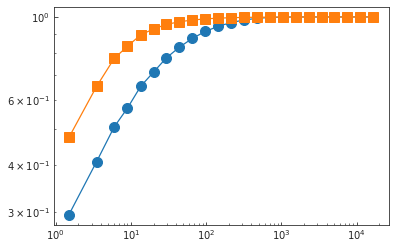

In [17]:
# CDF
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

aaa_data.sort()
aaa_urns.sort()

#plt.loglog(aaa_data, np.arange(aaa_data.size)/float(aaa_data.size))
#plt.loglog(aaa_urns, np.arange(aaa_urns.size)/float(aaa_urns.size))


f, b = np.histogram(aaa_data, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
cdf_data = np.cumsum(f*deltaB)
b_data = (b[:-1] + b[1:])/2.


f, b = np.histogram(aaa_urns, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
b_urns = (b[:-1] + b[1:])/2.
cdf_urns = np.cumsum(f*deltaB)
plt.loglog(b_data, cdf_data, "o-C0", ms=10, lw=1.25)
plt.loglog(b_urns, cdf_urns, "s-C1", ms=10, lw=1.25)

In [18]:
Beta_Opt = .47

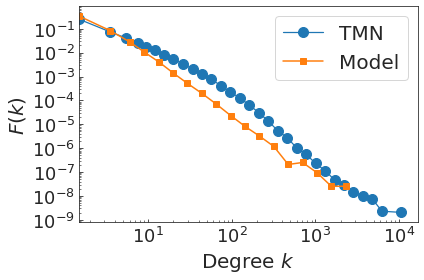

In [19]:
f, b = np.histogram(DATA["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.3), density=True)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]

f_u, b_u = np.histogram(DATA_urns["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]

sigma_exp = 2.75
offset_const = 1.5
theo_mu = ((1. + Beta_Opt)*res_nu[1] - Beta_Opt)
res_mu, cov_mu = curve_fit(powLaw, b_u, f_u, p0=[1., theo_mu],
        sigma=1./b_u**sigma_exp, bounds=((1e-8, theo_mu*.95), (1e8, theo_mu*1.05)))
res_mu[0] *= offset_const

plt.loglog(b, f, "-oC0", ms=10, lw=1.25, label="TMN")
plt.loglog(b_u, f_u, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_mu), "-C2", lw=2,
#           label=r"$F(k) \propto k^{-%.02f}$" % res_mu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_k.pdf"), bbox_inces="tight")

In [20]:
timeDates = XXXs = np.array(DATA_urns["TimeVecs"]["EventsT"])

In [21]:
XXXs = timeDates
YYYs = DATA["TimeVecs"]["EdgesActiveT"]
SSSs = 1./XXXs**.75

gamma_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXXs, YYYs, SSSs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_De, chi_De = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_De, np.sqrt(np.diag(chi_De))

[1.00000001e-04 1.58833911e+01 8.69551724e-01] [6.71322286e+03 9.64948016e-01 4.24855599e-03]


In [27]:
XXUs = np.array(DATA_urns["TimeVecs"]["EventsT"])
YYUs = DATA_urns["TimeVecs"]["EdgesActiveT"]
SSUs = 1./XXUs**.25

gamma_out_urns, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXUs, YYUs, SSUs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_DeU, chi_DeU = curve_fit(Power_Growth_foo, XXUs, YYUs, sigma=SSUs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_De, np.sqrt(np.diag(chi_De))

[1.00000001e-04 1.58833911e+01 8.69551724e-01] [6.71322286e+03 9.64948016e-01 4.24855599e-03]


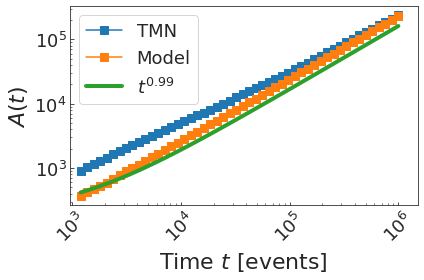

In [42]:
#plt.figure(figsize=(6,5))

offsetEmpirical = 9e-2

#plt.plot(timeDates, DATA["TimeVecs"]["NodesActiveT"], "o-C3",
#         ms=8, label=r"$D(t)$")
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_Ne), "--C9", lw=4,
#         label=r"$t^{%.02f}$" % res_Ne[2])

YYYs = np.array(DATA["TimeVecs"]["EdgesActiveT"])
plt.plot(timeDates, YYYs*offsetEmpirical, "sC0-", label=r"TMN",
        ms=8)
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_De), "--C1", lw=4,
#         label=r"$t^{%.02f}$" % res_De[2])

YYUs = np.array(DATA_urns["TimeVecs"]["EdgesActiveT"])
plt.plot(XXUs, 1.*YYUs, "sC1-", label=r"Model",
        ms=8)
plt.plot(XXUs, .7*Power_Growth_foo(XXUs, *res_DeU), "-C2", lw=4,
         label=r"$t^{%.02f}$" % res_DeU[2])


plt.xscale("log")
plt.yscale("log")
plt.xlim(XXXs[0]*.8, XXXs[-1]*1.5)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$A(t)$", size=22)
plt.legend(loc=2, fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges_modelVsEmpirical.pdf"), bbox_inces="tight")
#plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges.pdf"), bbox_inces="tight")

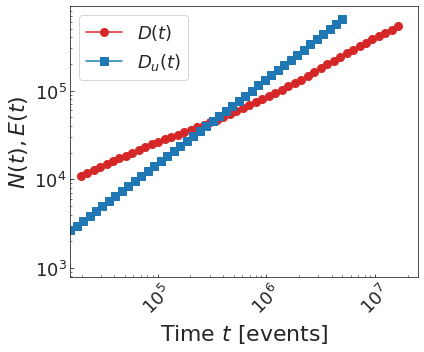

In [35]:
plt.figure(figsize=(6,5))
plt.plot(timeDates, DATA["TimeVecs"]["NodesActiveT"], "o-C3",
         ms=8, label=r"$D(t)$")
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_Ne), "--C9", lw=4,
#         label=r"$t^{%.02f}$" % res_Ne[2])

YYUs = DATA_urns["TimeVecs"]["NodesActiveT"]
plt.plot(XXUs, YYUs, "sC0-", label=r"$D_u(t)$",
        ms=8)


#YYYs = DATA["TimeVecs"]["EdgesActiveT"]
#plt.plot(timeDates, YYYs, "sC0-", label=r"$A(t)$",
#        ms=8)
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_De), "--C1", lw=4,
#         label=r"$t^{%.02f}$" % res_De[2])

#YYUs = np.array(DATA_urns["TimeVecs"]["EdgesActiveT"])
#plt.plot(XXUs, 1.*YYUs, "sC2-", label=r"$A_u(t)$",
#        ms=8)
#plt.plot(XXUs, .7*Power_Growth_foo(XXUs, *res_DeU), "--C4", lw=4,
#         label=r"$t^{%.02f}$" % res_DeU[2])


plt.xscale("log")
plt.yscale("log")
plt.xlim(XXXs[0]*.8, XXXs[-1]*1.5)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$N(t), E(t)$", size=22)
plt.legend(loc=2, fontsize=18)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges.pdf"), bbox_inces="tight")

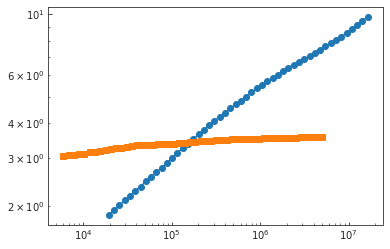

In [37]:
plt.loglog(DATA["TimeVecs"]["EventsT"],
           DATA["TimeVecs"]["KmeanT"], "o-")
plt.loglog(DATA_urns["TimeVecs"]["EventsT"],
           DATA_urns["TimeVecs"]["KmeanT"], "s-")

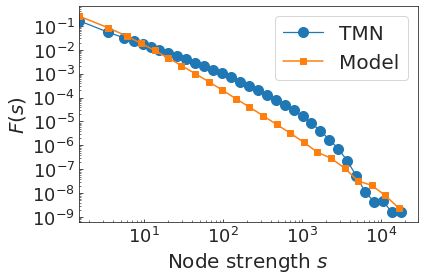

In [15]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Win"]) + np.array(DATA["Arrays"]["Act"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Win"]) + np.array(DATA_urns["Arrays"]["Act"])


f, b = np.histogram(www_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=True)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.5),
                        density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]

sigma_exp = 2.75
offset_const = 1.5
theo_mu = ((1. + Beta_Opt)*res_nu[1] - Beta_Opt)
res_mu, cov_mu = curve_fit(powLaw, b_u, f_u, p0=[1., theo_mu],
        sigma=1./b_u**sigma_exp, bounds=((1e-8, theo_mu*.95), (1e8, theo_mu*1.05)))
res_mu[0] *= offset_const

plt.loglog(b, f, "-oC0", ms=10, lw=1.25, label="TMN")
plt.loglog(b_u, f_u, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_mu), "-C2", lw=2,
#           label=r"$F(k) \propto k^{-%.02f}$" % res_mu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Node strength $s$", size=20)
plt.ylabel(r"$F(s)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_s.pdf"),
            bbox_inces="tight")

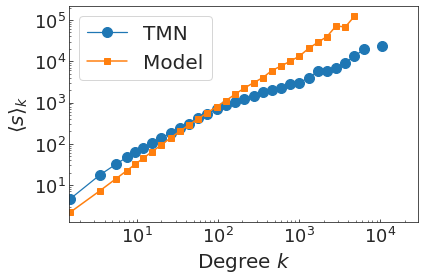

In [21]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Act"]) + np.array(DATA["Arrays"]["Win"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Act"]) + np.array(DATA_urns["Arrays"]["Win"])

f, b = np.histogram(kkk_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=False)

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.3),
                        density=False)

# Now for each bin compute the average strength
avg_www_data = np.array([np.mean(
    www_data[
        np.logical_and(kkk_data>=b[i], kkk_data<b[i+1])
    ])  for i in range(len(b)-1)
])
b = (b[:-1] + b[1:])/2.

avg_www_urns = np.array([np.mean(
    www_urns[
        np.logical_and(kkk_urns>=b_u[i], kkk_urns<b_u[i+1])
    ])  for i in range(len(b_u)-1)
])
b_u = (b_u[:-1] + b_u[1:])/2.


plt.loglog(b, avg_www_data, "-oC0", ms=10, lw=1.25, label="TMN")
plt.loglog(b_u, avg_www_urns, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$\langle s \rangle_k$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/avgWeightVsDegree.pdf"),
            bbox_inces="tight")

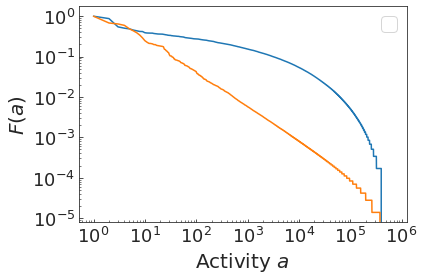

In [33]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(aaa_data)+1), aaa_data[np.argsort(aaa_data)[::-1]]/float(max(aaa_data)))
plt.loglog(np.arange(1, len(aaa_urns)+1), aaa_urns[np.argsort(aaa_urns)[::-1]]/float(max(aaa_urns)))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

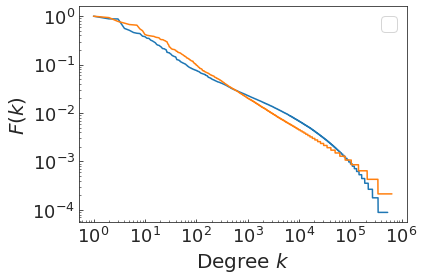

In [34]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(kkk_data)+1), kkk_data[np.argsort(kkk_data)[::-1]]/max(kkk_data))
plt.loglog(np.arange(1, len(kkk_urns)+1), kkk_urns[np.argsort(kkk_urns)[::-1]]/max(kkk_urns))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

In [12]:
DATA["Arrays"].keys()

['Win', 'Kout', 'IDs', 'Entr', 'Kin', 'Act', 'Deg']

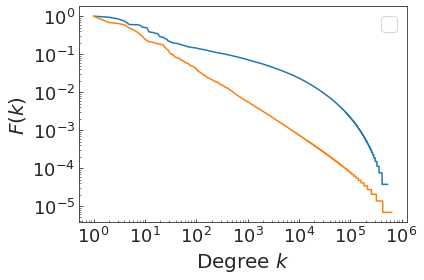

In [13]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Win"]) + np.array(DATA["Arrays"]["Act"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Win"]) + np.array(DATA_urns["Arrays"]["Act"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(www_data)+1), www_data[np.argsort(www_data)[::-1]]/max(www_data))
plt.loglog(np.arange(1, len(www_urns)+1), www_urns[np.argsort(www_urns)[::-1]]/max(www_urns))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

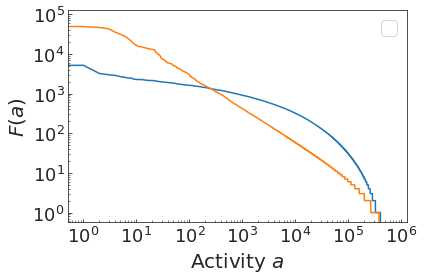

In [35]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(aaa_data[np.argsort(aaa_data)[::-1]])
plt.loglog(aaa_urns[np.argsort(aaa_urns)[::-1]])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

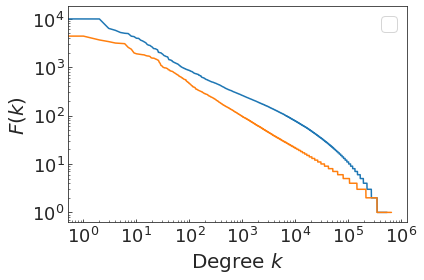

In [36]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(kkk_data[np.argsort(kkk_data)[::-1]])
plt.loglog(kkk_urns[np.argsort(kkk_urns)[::-1]])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

## The $\langle k(a,t)\rangle_a$...

In [262]:
# Select the aggregator of classes...
currentSuperClass = lambda classID: classID[:1]
tmpBins = DATA["Bins"]["Bins"]
selectedSuperClasses = [(0,), (1,), (2,), (4,), (12,), (16,), (20,), (22,), (24,)]
selectedSuperClasses = [(i,) for i in range(17, len(tmpBins["b"])-8, 1)]

activityString = "a" if binningScheme in ("ak", "eak") else "e"

# Fitting classes to account...
classFrom, classTo = 0, len(selectedSuperClasses)
fit_from = .6e+1

# plotting the fit from to, moving it by...
fit_plot_interval, fit_offset = np.logspace(1.05, 3.), .75

# x axis limit (set to None for free plot)
xlim = (9e-1, 3e2)
ylim = (1e-0, 1e2)

In [263]:
def avgAct(DATA, nodeClass, activityStr="a"):
    tmpBin = DATA["Bins"]["Bins"]
    binningScheme = DATA["Params"]["binningScheme"]
    i = -1
    for i in range(binningScheme.index(activityStr)):
        tmpBin = tmpBin["v"][nodeClass[i]]
    return sum(tmpBin["b"][nodeClass[i+1]:nodeClass[i+1]+1])/2.

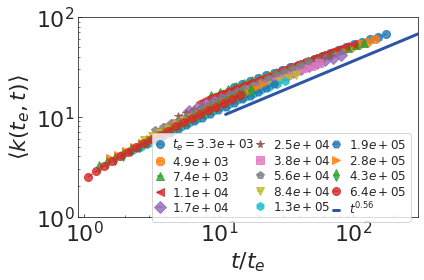

In [264]:
kat = DATA['pkt']

acts = np.array(DATA['Arrays']['Act'])
max_act = acts.max()
acts /= max_act
avg_act = acts.sum()/len(acts)
plt.figure(figsize=(6,4))

Fit_X, Fit_Y = [], []
firstPlot = True
for superClass in sorted(selectedSuperClasses):
    # kat[act_class]
    degsFreqs = {}
    validKeys = [nodeClass for nodeClass in sorted(Pakt.keys()) if currentSuperClass(nodeClass) == superClass]
    #print validKeys
    for nodeClass in validKeys:
        Res = Pakt[nodeClass]
        for time, Values in Res.iteritems():
            if time not in Times:
                continue
            for tmpDeg, tmpFreq in Values.iteritems():
                degsFreqs.setdefault(time, {"k": .0, "n": .0})
                degsFreqs[time]["k"] += tmpDeg*tmpFreq
                degsFreqs[time]["n"] += tmpFreq        
    if len(degsFreqs) < 2: continue
        
    # Define something similar to mindeg to compute the avg act...
    act_tmp = avgAct(DATA, nodeClass, activityStr=activityString)
    
    X = np.array([float(DATA["TimeVecs"]["EventsT"][k]) for k, v in sorted(degsFreqs.items())])
    X *= max_act/X[-1]########
    
    #Y = np.array([v["k"]/v["n"] for k, v in sorted(degsFreqs.items())])
    Y = np.array([v["k"]/degsFreqs[max(degsFreqs.keys())]["n"] for k, v in sorted(degsFreqs.items())])
    
    if activityString == "a":
        ####### X *= act_tmp + avg_act
        X *= act_tmp/max_act + avg_act
    elif activityString == "e":
        X /= act_tmp**.475
    
    plt.loglog(X, Y, '--', label=r"$t_e=$"*firstPlot 
               + r"$%.01e$" % DATA["Bins"]["Bins"]["b"][superClass[0]],
               marker=markers[selectedSuperClasses.index(superClass)%len(markers)],\
               ms=8, alpha=.8, lw=1.5)#, label="%02d"%act_class)
    if firstPlot: firstPlot = False
    
    if superClass in selectedSuperClasses[classFrom:classTo]:
        Fit_X.append(X[X>=fit_from])
        Fit_Y.append(Y[X>=fit_from])

pars_out = []
chi2_out = []
for curveX, curveY in zip(Fit_X, Fit_Y):
    if len(curveX) < 5: continue
    par_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., .5, 1e-6],
        args=(curveX, curveY), bounds=[(1e-8, 1e+8), (0.025, 1.025), (.0, 1e-4)],
        approx_grad=True, maxfun=1000000, maxiter=1000000)
    pars_out.append(par_out)
    chi2_out.append(chi2_tmp)
    
bestExp = np.average([p[1] for p in pars_out],
                      weights=[1./max(1e-3, c) for c in chi2_out])
bestPars = (pars_out[-1][0], bestExp, pars_out[-1][2])
par_out_emp, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth,
        x0=bestPars, args=(Fit_X[-1], Fit_Y[-1], 1./Fit_X[-1]), bounds=[(1e-8, 1e+8),
                                                          (bestExp*.9999, bestExp*1.0001),
                                                          (.0, 1e-4)],
        approx_grad=True, maxfun=1000000, maxiter=1000000)

bestBeta = (1./bestExp - 1.)
plt.loglog(fit_plot_interval, fit_offset*Power_Growth(par_out_emp, fit_plot_interval), '-',
           label=r"$t^{%.02f}$"%bestExp, color="#2c55a3", lw=3)

par_out_theor, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(Power_Growth, x0=[1., 1./(1.+Beta_Opt), 1e-6],\
        args=(Fit_X[-1], Fit_Y[-1], 1./Fit_X[-1]), bounds=[(1e-8, 1e+8), (1./(1.+Beta_Opt)*.9999, 1./(1.+Beta_Opt)*1.0001), (.0, 1e-4)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)
#plt.loglog(fit_plot_interval, .75*fit_offset*Power_Growth(par_out_theor, fit_plot_interval), '--',\
#           label=r"$\beta_{\rm opt}=%.02f$"%Beta_Opt, color="#2c55a3", lw=2.5)

plt.xticks(size=22)
plt.yticks(size=22)

if binningScheme in ["ak", "eak"]:
    plt.xlabel(r"$t \left(\langle a\rangle + a\right)$", size=22)
    plt.ylabel(r"$\langle k(a,t)\rangle$", size=22)
elif binningScheme in ["ek"]:
    plt.xlabel(r"$t / t_e$", size=22)
    plt.ylabel(r"$\langle k(t_e,t)\rangle$", size=22)

if True:
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

plt.legend(loc="upper left", fontsize=12, ncol=3,
           handlelength=.5, bbox_to_anchor=(.2,.45), labelspacing=.2,
          columnspacing=.2)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/%s_kat_eve.pdf"
                         % (binningScheme)), bbox_inches='tight')

In [265]:
Beta_Opt, activityString, bestExp, bestBeta

(0.46, 'e', 0.5643512441442392, 0.7719461246450552)

0.5631478604773538 0.0662283561587152


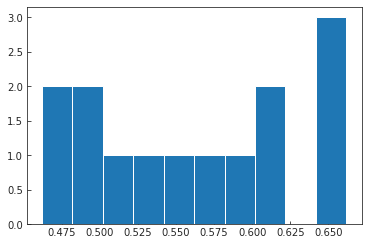

In [266]:
res_exps = np.array([p[1] for p in pars_out])
plt.hist(res_exps)

print np.mean(res_exps), np.std(res_exps)

## The time-depending observables

In [5]:
from scipy.optimize import curve_fit

In [6]:
timeEvents = np.array(DATA["TimeVecs"]["EventsT"])

In [7]:
## Set once and for all the vector of dates linked with the number of events (i.e., the positions in the TVec vector)
timeDates = []
useDates = False

if useDates:
    import datetime
    eventsCounter = 0
    for fname in sorted(os.listdir(dataDir)):
        if fname.startswith("."):
            continue
        with open(os.path.join(dataDir, fname)) as tmp_file:
            for line in tmp_file:
                vals = line.strip().split()
                if vals[0] == vals[1]:
                    continue

                eventsCounter += 1
                if eventsCounter >= DATA["TimeVecs"]["EventsT"][len(timeDates)]:
                    tmp_date = "_".join(fname.split("_")[-2:])
                    timeDates.append(datetime.datetime.strptime(tmp_date, "%Y_%m.dat"))
    timeDates = np.array(timeDates)
else:
    timeDates = timeEvents
print len(timeEvents) == len(timeDates)

True


In [8]:
selectedTime = timeEvents # timeEvents or timeDates

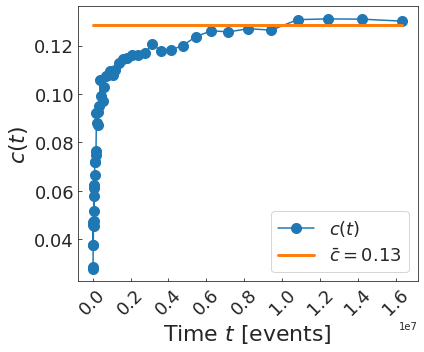

In [271]:
def asymptoticLevel(x, y0):
    return np.ones(len(x))*y0

plt.figure(figsize=(6,5))

XXXs, YYYs = timeEvents, DATA["TimeVecs"]["Clust_t"]
SSSs = 1./(XXXs + 1.)
plt.plot(XXXs, YYYs, "o-", label=r"$c(t)$", ms=10)

p_res, c_res = curve_fit(asymptoticLevel, XXXs, YYYs, sigma=SSSs, p0=(.5), bounds=(1e-5, 1.))
plt.plot(XXXs, asymptoticLevel(XXXs, *p_res), '-C1', lw=3, label=r"$\bar c=%.02f$" % p_res[0])

plt.xscale("linear")
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$c(t)$", size=22)
plt.legend(loc="best", fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/clustering_t.pdf"), bbox_inces="tight")

In [272]:
# Asymptotic fluctuations
clustAsymptStart = 4e6

XXXs, YYYs = np.array(timeEvents), np.array(DATA["TimeVecs"]["Clust_t"])
SSSs = 1./(XXXs + 1.)

YYYs = YYYs[XXXs >= clustAsymptStart]
SSSs = SSSs[XXXs >= clustAsymptStart]
XXXs = XXXs[XXXs >= clustAsymptStart]

print np.mean(YYYs), np.std(YYYs)

0.12634591938860223 0.004157118330320375


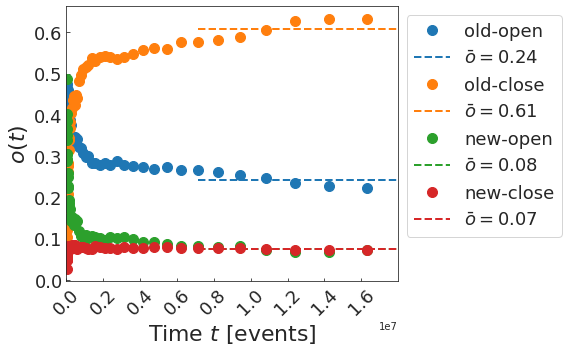

In [273]:
totEve_t = np.array(DATA["TimeVecs"]["newCloseTriang"]) + np.array(DATA["TimeVecs"]["newOpenTriang"])+\
          np.array(DATA["TimeVecs"]["oldOpenTriang"]) +  np.array(DATA["TimeVecs"]["oldCloseTriang"])
selectedTime = timeEvents

plt.figure(figsize=(8,5))
colorIDX = 0
for what, label in zip(
            ["oldOpenTriang", "oldCloseTriang", "newOpenTriang", "newCloseTriang"],
            ["old-open", "old-close", "new-open", "new-close"]
        ):
    XXXs, YYYs = selectedTime, np.array(DATA["TimeVecs"][what],dtype=float)/totEve_t
    SSSs = 1./(XXXs + 1.)
    plt.plot(XXXs, YYYs, "oC%d" % colorIDX, label=label, ms=10)
    p_res, c_res = curve_fit(asymptoticLevel, XXXs, YYYs, sigma=SSSs, p0=(.5), bounds=(1e-5, 1.))
    XTheo = XXXs[len(XXXs)*4/5:]*1.5
    plt.plot(XTheo, asymptoticLevel(XTheo, *p_res), '--C%d' % colorIDX, lw=2,
             label=r"$\bar o = %.02f$" % p_res[0])      
    colorIDX += 1
             
plt.xscale("linear")
plt.xlim(-10, XXXs[-1]*1.1)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$o(t)$", size=22)
plt.legend(loc="upper left", fontsize=18, bbox_to_anchor=(1,1))

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/oldNew_openClose_triangles.pdf"), bbox_inces="tight")

In [274]:
# Asymptotic fluctuations
clustAsymptStart = 6e6

selectedTime = np.array(timeEvents)
for what, label in zip(
            ["oldOpenTriang", "oldCloseTriang", "newOpenTriang", "newCloseTriang"],
            ["old-open", "old-close", "new-open", "new-close"]
        ):
    
    XXXs, YYYs = selectedTime, np.array(DATA["TimeVecs"][what],dtype=float)/totEve_t
    SSSs = 1./(XXXs + 1.)

    YYYs = YYYs[XXXs >= clustAsymptStart]
    SSSs = SSSs[XXXs >= clustAsymptStart]
    XXXs = XXXs[XXXs >= clustAsymptStart]

    print label, np.mean(YYYs), np.std(YYYs)

old-open 0.24749646839626696 0.016124862427021398
old-close 0.6023613397791102 0.02324290067907639
new-open 0.07529333353250398 0.005899555356595161
new-close 0.07484885829211879 0.0018259741500338271


In [32]:
XXXs = timeDates
YYYs = DATA["TimeVecs"]["EdgesActiveT"]
SSSs = 1./XXXs**.75

gamma_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXXs, YYYs, SSSs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_De, chi_De = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_De, np.sqrt(np.diag(chi_De))

[0.0813189  1.40026555 0.86955047] [6.71364324e+03 1.01688762e-01 4.24885981e-03]


In [276]:
XXXs = timeDates
YYYs = DATA["TimeVecs"]["NodesActiveT"]
SSSs = 1./XXXs**.75

gamma_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXXs, YYYs, SSSs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_Ne, chi_Ne = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_Ne, np.sqrt(np.diag(chi_Ne))

[1.00000002e-04 1.16538852e+01 6.46605887e-01] [5.34816199e+03 2.22611795e+00 1.09799784e-02]


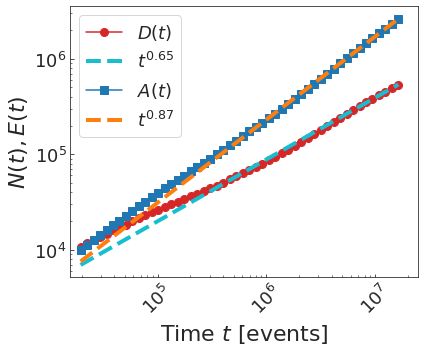

In [33]:
plt.figure(figsize=(6,5))
plt.plot(timeDates, DATA["TimeVecs"]["NodesActiveT"], "o-C3",
         ms=8, label=r"$D(t)$")
plt.plot(XXXs, Power_Growth_foo(XXXs, *res_Ne), "--C9", lw=4,
         label=r"$t^{%.02f}$" % res_Ne[2])

YYYs = DATA["TimeVecs"]["EdgesActiveT"]
plt.plot(timeDates, YYYs, "sC0-", label=r"$A(t)$",
        ms=8)
plt.plot(XXXs, Power_Growth_foo(XXXs, *res_De), "--C1", lw=4,
         label=r"$t^{%.02f}$" % res_De[2])


plt.xscale("log")
plt.yscale("log")
plt.xlim(XXXs[0]*.8, XXXs[-1]*1.5)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$N(t), E(t)$", size=22)
plt.legend(loc=2, fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges.pdf"), bbox_inces="tight")

In [278]:
dic_out

{'funcalls': 188,
 'grad': array([2.78290596e+18, 7.95691215e+20, 2.98270720e+15]),
 'nit': 20,
 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'warnflag': 0}

## Cumulative degree and weights

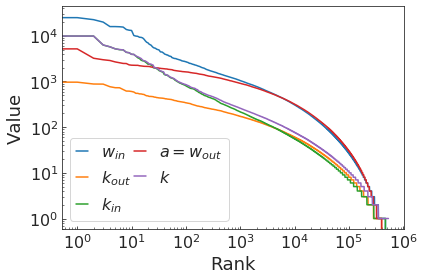

In [279]:
labelDict = {
    "Win":  r"$w_{in}$",
    "Kout": r"$k_{out}$",
    "Kin":  r"$k_{in}$",
    "Act":  r"$a = w_{out}$",
    "Deg":  r"$k$",
}

for what, arra in DATA["Arrays"].iteritems():
    if what in ["IDs", "Entr"]:
        continue
    plt.loglog(np.sort(arra)[::-1], label=labelDict[what])

plt.xlabel("Rank", size=18)
plt.ylabel("Value", size=18)

plt.xticks(size=16)
plt.yticks(size=16)

plt.legend(loc="best", fontsize=16,
           ncol=2, columnspacing=.2, handlelength=.75)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/rank_plot.pdf"), bbox_inces="tight")

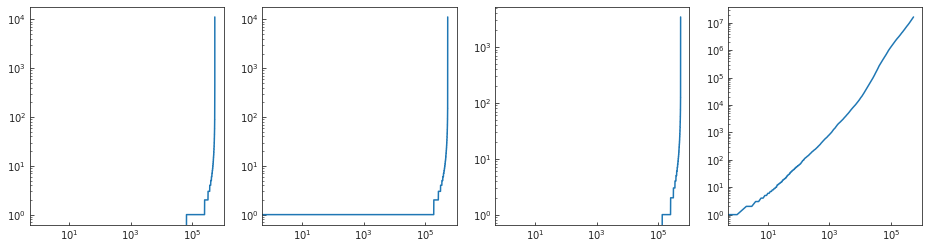

In [280]:
fig = plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.loglog(np.sort(DATA["Arrays"]["Kin"]))
plt.subplot(1,4,2)
plt.loglog(np.sort(DATA["Arrays"]["Deg"]))
plt.subplot(1,4,3)
plt.loglog(np.sort(DATA["Arrays"]["Kout"]))
plt.subplot(1,4,4)
plt.loglog(np.sort(DATA["Arrays"]["Entr"]))

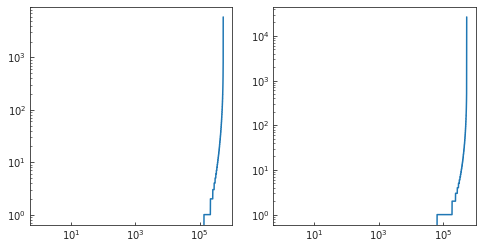

In [281]:
fig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.loglog(np.sort(DATA["Arrays"]["Act"]))
plt.subplot(1,2,2)
plt.loglog(np.sort(DATA["Arrays"]["Win"]))

In [24]:
Beta_Opt

0.5

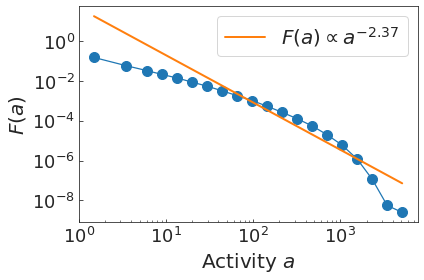

In [8]:
f, b = np.histogram(DATA["Arrays"]["Act"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]
res_nu, cov_nu = curve_fit(powLaw, b, f, p0=[1., -1.], sigma=1./b**2.5, bounds=((1e-8, -3.1), (1e8, 3.1)))

plt.loglog(b, f, "o-C0", ms=10, lw=1.25)
plt.loglog(b, powLaw(b, *res_nu), "-C1", lw=2,
           label=r"$F(a) \propto a^{-%.02f}$" % res_nu[1])

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

In [11]:
dat_file_name_urns = "/home/ubi/urns_serie/out/Symm_SonsExchg0_StrctSmpl1_r05_n05_t000001000000_Run_03/data/networkStats_a125_k125_e150_stBySt1_tScheve_bSchek.dat.gz"
DATA_urns = cPickle.load(gzip.open(dat_file_name_urns, 'rb'))

In [12]:
Beta_Opt = .5

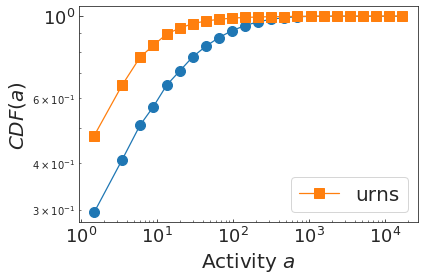

In [13]:
# CDF
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

aaa_data.sort()
aaa_urns.sort()

#plt.loglog(aaa_data, np.arange(aaa_data.size)/float(aaa_data.size))
#plt.loglog(aaa_urns, np.arange(aaa_urns.size)/float(aaa_urns.size))


f, b = np.histogram(aaa_data, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
cdf_data = np.cumsum(f*deltaB)
b = (b[:-1] + b[1:])/2.
plt.loglog(b, cdf_data, "o-C0", ms=10, lw=1.25)

f, b = np.histogram(aaa_urns, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
b = (b[:-1] + b[1:])/2.
cdf_urns = np.cumsum(f*deltaB)
plt.loglog(b, cdf_urns, "s-C1", ms=10, lw=1.25, label="urns")

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$CDF(a)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a_cdf.pdf"), bbox_inces="tight")

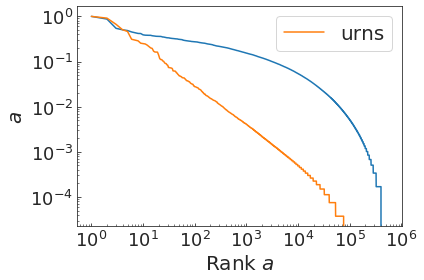

In [14]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(aaa_data)+1), aaa_data[np.argsort(aaa_data)[::-1]]/float(max(aaa_data)))
plt.loglog(np.arange(1, len(aaa_urns)+1), aaa_urns[np.argsort(aaa_urns)[::-1]]/float(max(aaa_urns)), label="urns")
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Rank $a$", size=20)
plt.ylabel(r"$a$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a_freqRank.pdf"), bbox_inces="tight")

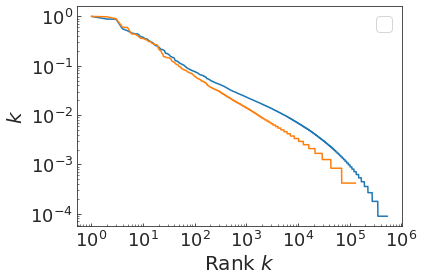

In [15]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(kkk_data)+1), kkk_data[np.argsort(kkk_data)[::-1]]/max(kkk_data))
plt.loglog(np.arange(1, len(kkk_urns)+1), kkk_urns[np.argsort(kkk_urns)[::-1]]/max(kkk_urns))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Rank $k$", size=20)
plt.ylabel(r"$k$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_k_freqRank.pdf"), bbox_inces="tight")
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

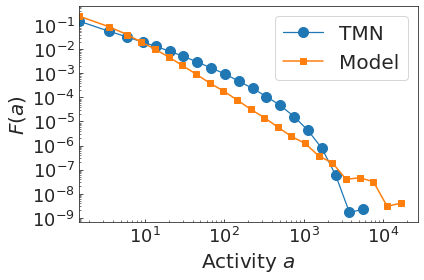

In [16]:
f, b = np.histogram(DATA["Arrays"]["Act"], bins =Lin_Log_Bins(1, 50000, factor=1.5), density=True)
from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]
plt.loglog(b, f, "o-C0", ms=10, lw=1.25, label="TMN")

f_u, b_u = np.histogram(DATA_urns["Arrays"]["Act"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]
plt.loglog(b_u, f_u, "s-C1", label="Model")

res_nu, cov_nu = curve_fit(powLaw, b_u, f_u,
                           p0=[1., -1.], sigma=1./b_u**2.5,
                           bounds=((1e-8, -3.1), (1e8, 3.1)))

b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_nu), "-C2", lw=2,
#           label=r"$F(a) \propto a^{-%.02f}$" % res_nu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

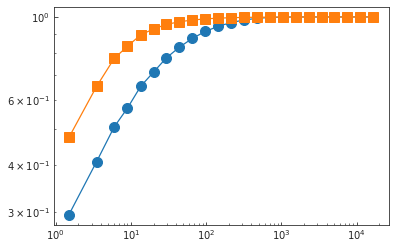

In [17]:
# CDF
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

aaa_data.sort()
aaa_urns.sort()

#plt.loglog(aaa_data, np.arange(aaa_data.size)/float(aaa_data.size))
#plt.loglog(aaa_urns, np.arange(aaa_urns.size)/float(aaa_urns.size))


f, b = np.histogram(aaa_data, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
cdf_data = np.cumsum(f*deltaB)
b_data = (b[:-1] + b[1:])/2.


f, b = np.histogram(aaa_urns, bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
deltaB = np.diff(b)
b_urns = (b[:-1] + b[1:])/2.
cdf_urns = np.cumsum(f*deltaB)
plt.loglog(b_data, cdf_data, "o-C0", ms=10, lw=1.25)
plt.loglog(b_urns, cdf_urns, "s-C1", ms=10, lw=1.25)

In [18]:
Beta_Opt = .47

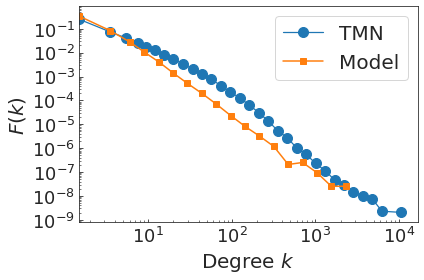

In [19]:
f, b = np.histogram(DATA["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.3), density=True)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]

f_u, b_u = np.histogram(DATA_urns["Arrays"]["Deg"], bins =Lin_Log_Bins(1, 20000, factor=1.5), density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]

sigma_exp = 2.75
offset_const = 1.5
theo_mu = ((1. + Beta_Opt)*res_nu[1] - Beta_Opt)
res_mu, cov_mu = curve_fit(powLaw, b_u, f_u, p0=[1., theo_mu],
        sigma=1./b_u**sigma_exp, bounds=((1e-8, theo_mu*.95), (1e8, theo_mu*1.05)))
res_mu[0] *= offset_const

plt.loglog(b, f, "-oC0", ms=10, lw=1.25, label="TMN")
plt.loglog(b_u, f_u, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_mu), "-C2", lw=2,
#           label=r"$F(k) \propto k^{-%.02f}$" % res_mu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_k.pdf"), bbox_inces="tight")

In [20]:
timeDates = XXXs = np.array(DATA_urns["TimeVecs"]["EventsT"])

In [21]:
XXXs = timeDates
YYYs = DATA["TimeVecs"]["EdgesActiveT"]
SSSs = 1./XXXs**.75

gamma_out, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXXs, YYYs, SSSs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_De, chi_De = curve_fit(Power_Growth_foo, XXXs, YYYs, sigma=SSSs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_De, np.sqrt(np.diag(chi_De))

[1.00000001e-04 1.58833911e+01 8.69551724e-01] [6.71322286e+03 9.64948016e-01 4.24855599e-03]


In [27]:
XXUs = np.array(DATA_urns["TimeVecs"]["EventsT"])
YYUs = DATA_urns["TimeVecs"]["EdgesActiveT"]
SSUs = 1./XXUs**.25

gamma_out_urns, chi2_tmp, dic_out = optimize.fmin_l_bfgs_b(
    Power_Growth, x0=[1., .5, 1e-6],
    args=(XXUs, YYUs, SSUs), bounds=[(1e-8, 1e+8), (.1, 1.1), (.0, 1e2)],\
        approx_grad=True, maxfun=1000000, maxiter=1000000)

def Power_Growth_foo(x, A, B, C):
    return A + B * x**C

res_DeU, chi_DeU = curve_fit(Power_Growth_foo, XXUs, YYUs, sigma=SSUs,
                           p0=(1e-4, 1e3, 1.), bounds=(1e-4, 1e6))

print res_De, np.sqrt(np.diag(chi_De))

[1.00000001e-04 1.58833911e+01 8.69551724e-01] [6.71322286e+03 9.64948016e-01 4.24855599e-03]


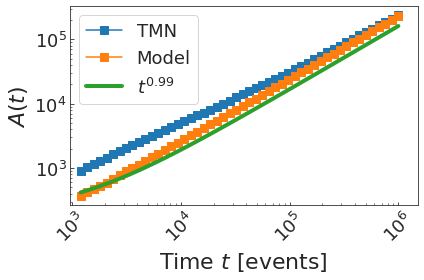

In [42]:
#plt.figure(figsize=(6,5))

offsetEmpirical = 9e-2

#plt.plot(timeDates, DATA["TimeVecs"]["NodesActiveT"], "o-C3",
#         ms=8, label=r"$D(t)$")
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_Ne), "--C9", lw=4,
#         label=r"$t^{%.02f}$" % res_Ne[2])

YYYs = np.array(DATA["TimeVecs"]["EdgesActiveT"])
plt.plot(timeDates, YYYs*offsetEmpirical, "sC0-", label=r"TMN",
        ms=8)
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_De), "--C1", lw=4,
#         label=r"$t^{%.02f}$" % res_De[2])

YYUs = np.array(DATA_urns["TimeVecs"]["EdgesActiveT"])
plt.plot(XXUs, 1.*YYUs, "sC1-", label=r"Model",
        ms=8)
plt.plot(XXUs, .7*Power_Growth_foo(XXUs, *res_DeU), "-C2", lw=4,
         label=r"$t^{%.02f}$" % res_DeU[2])


plt.xscale("log")
plt.yscale("log")
plt.xlim(XXXs[0]*.8, XXXs[-1]*1.5)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$A(t)$", size=22)
plt.legend(loc=2, fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges_modelVsEmpirical.pdf"), bbox_inces="tight")
#plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges.pdf"), bbox_inces="tight")

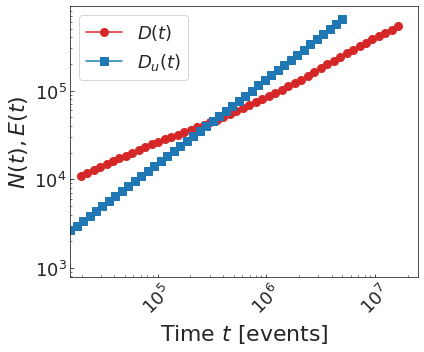

In [35]:
plt.figure(figsize=(6,5))
plt.plot(timeDates, DATA["TimeVecs"]["NodesActiveT"], "o-C3",
         ms=8, label=r"$D(t)$")
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_Ne), "--C9", lw=4,
#         label=r"$t^{%.02f}$" % res_Ne[2])

YYUs = DATA_urns["TimeVecs"]["NodesActiveT"]
plt.plot(XXUs, YYUs, "sC0-", label=r"$D_u(t)$",
        ms=8)


#YYYs = DATA["TimeVecs"]["EdgesActiveT"]
#plt.plot(timeDates, YYYs, "sC0-", label=r"$A(t)$",
#        ms=8)
#plt.plot(XXXs, Power_Growth_foo(XXXs, *res_De), "--C1", lw=4,
#         label=r"$t^{%.02f}$" % res_De[2])

#YYUs = np.array(DATA_urns["TimeVecs"]["EdgesActiveT"])
#plt.plot(XXUs, 1.*YYUs, "sC2-", label=r"$A_u(t)$",
#        ms=8)
#plt.plot(XXUs, .7*Power_Growth_foo(XXUs, *res_DeU), "--C4", lw=4,
#         label=r"$t^{%.02f}$" % res_DeU[2])


plt.xscale("log")
plt.yscale("log")
plt.xlim(XXXs[0]*.8, XXXs[-1]*1.5)
plt.xticks(size=18, rotation=45)
plt.yticks(size=18)
plt.xlabel(r"Time $t$ [events]", size=22)
plt.ylabel(r"$N(t), E(t)$", size=22)
plt.legend(loc=2, fontsize=18)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "kat/active_nodesEdges.pdf"), bbox_inces="tight")

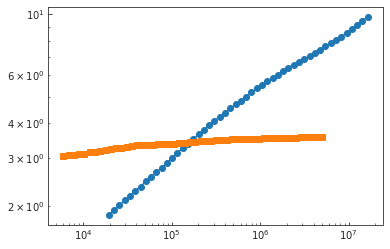

In [37]:
plt.loglog(DATA["TimeVecs"]["EventsT"],
           DATA["TimeVecs"]["KmeanT"], "o-")
plt.loglog(DATA_urns["TimeVecs"]["EventsT"],
           DATA_urns["TimeVecs"]["KmeanT"], "s-")

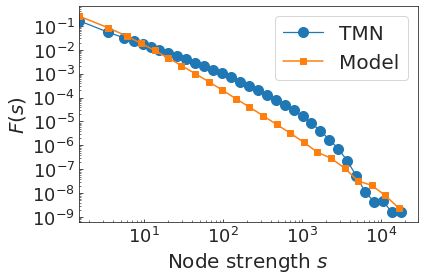

In [15]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Win"]) + np.array(DATA["Arrays"]["Act"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Win"]) + np.array(DATA_urns["Arrays"]["Act"])


f, b = np.histogram(www_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=True)

b = (b[:-1] + b[1:])/2.
b = b[f>0]
f = f[f>0]

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.5),
                        density=True)
b_u = (b_u[1:]+b_u[:-1])/2.
b_u = b_u[f_u>0]
f_u = f_u[f_u>0]

sigma_exp = 2.75
offset_const = 1.5
theo_mu = ((1. + Beta_Opt)*res_nu[1] - Beta_Opt)
res_mu, cov_mu = curve_fit(powLaw, b_u, f_u, p0=[1., theo_mu],
        sigma=1./b_u**sigma_exp, bounds=((1e-8, theo_mu*.95), (1e8, theo_mu*1.05)))
res_mu[0] *= offset_const

plt.loglog(b, f, "-oC0", ms=10, lw=1.25, label="TMN")
plt.loglog(b_u, f_u, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)
#plt.loglog(b_XXX, powLaw(b_XXX, *res_mu), "-C2", lw=2,
#           label=r"$F(k) \propto k^{-%.02f}$" % res_mu[1])

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Node strength $s$", size=20)
plt.ylabel(r"$F(s)$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/F_s.pdf"),
            bbox_inces="tight")

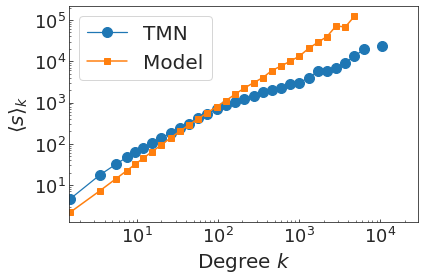

In [21]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Act"]) + np.array(DATA["Arrays"]["Win"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Act"]) + np.array(DATA_urns["Arrays"]["Win"])

f, b = np.histogram(kkk_data,
                    bins =Lin_Log_Bins(1, 20000, factor=1.3),
                    density=False)

f_u, b_u = np.histogram(www_urns,
                        bins =Lin_Log_Bins(1, 20000, factor=1.3),
                        density=False)

# Now for each bin compute the average strength
avg_www_data = np.array([np.mean(
    www_data[
        np.logical_and(kkk_data>=b[i], kkk_data<b[i+1])
    ])  for i in range(len(b)-1)
])
b = (b[:-1] + b[1:])/2.

avg_www_urns = np.array([np.mean(
    www_urns[
        np.logical_and(kkk_urns>=b_u[i], kkk_urns<b_u[i+1])
    ])  for i in range(len(b_u)-1)
])
b_u = (b_u[:-1] + b_u[1:])/2.


plt.loglog(b, avg_www_data, "-oC0", ms=10, lw=1.25, label="TMN")
plt.loglog(b_u, avg_www_urns, "s-C1", label="Model")
b_XXX = np.logspace(np.log10(min(min(b), min(b_u)))*.95,
                    np.log10(max(max(b), max(b_u)))*1.05, 20)

plt.xlim(b_XXX[0], b_XXX[-1])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$\langle s \rangle_k$", size=20)
plt.legend(loc="best", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/avgWeightVsDegree.pdf"),
            bbox_inces="tight")

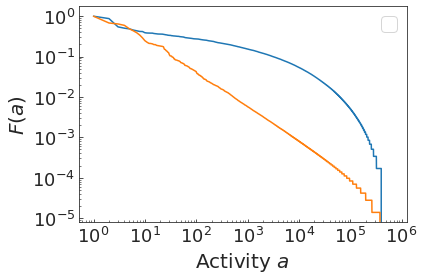

In [33]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(aaa_data)+1), aaa_data[np.argsort(aaa_data)[::-1]]/float(max(aaa_data)))
plt.loglog(np.arange(1, len(aaa_urns)+1), aaa_urns[np.argsort(aaa_urns)[::-1]]/float(max(aaa_urns)))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

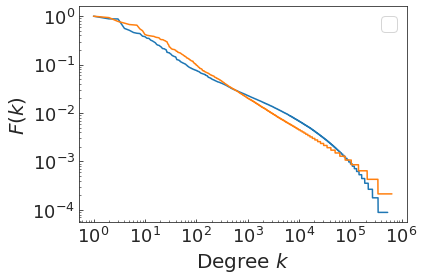

In [34]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(kkk_data)+1), kkk_data[np.argsort(kkk_data)[::-1]]/max(kkk_data))
plt.loglog(np.arange(1, len(kkk_urns)+1), kkk_urns[np.argsort(kkk_urns)[::-1]]/max(kkk_urns))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

In [12]:
DATA["Arrays"].keys()

['Win', 'Kout', 'IDs', 'Entr', 'Kin', 'Act', 'Deg']

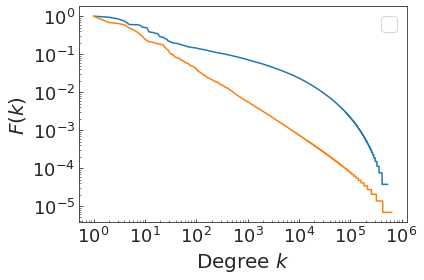

In [13]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])
www_data = np.array(DATA["Arrays"]["Win"]) + np.array(DATA["Arrays"]["Act"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])
www_urns = np.array(DATA_urns["Arrays"]["Win"]) + np.array(DATA_urns["Arrays"]["Act"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(np.arange(1, len(www_data)+1), www_data[np.argsort(www_data)[::-1]]/max(www_data))
plt.loglog(np.arange(1, len(www_urns)+1), www_urns[np.argsort(www_urns)[::-1]]/max(www_urns))
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

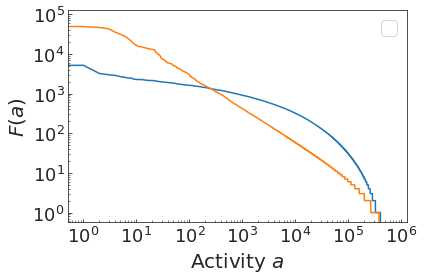

In [35]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(aaa_data[np.argsort(aaa_data)[::-1]])
plt.loglog(aaa_urns[np.argsort(aaa_urns)[::-1]])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Activity $a$", size=20)
plt.ylabel(r"$F(a)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

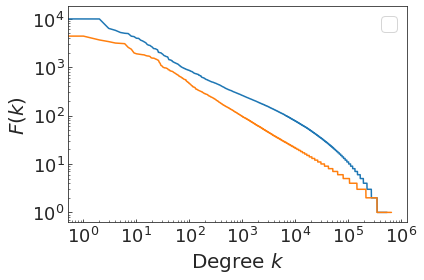

In [36]:
aaa_data = np.array(DATA["Arrays"]["Act"])
kkk_data = np.array(DATA["Arrays"]["Deg"])

aaa_urns = np.array(DATA_urns["Arrays"]["Act"])
kkk_urns = np.array(DATA_urns["Arrays"]["Deg"])

from scipy.optimize import curve_fit

def powLaw(x, const, esponent):
    return const * x**(-esponent)


plt.loglog(kkk_data[np.argsort(kkk_data)[::-1]])
plt.loglog(kkk_urns[np.argsort(kkk_urns)[::-1]])
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel(r"Degree $k$", size=20)
plt.ylabel(r"$F(k)$", size=20)
plt.legend(loc=1, fontsize=20)

plt.tight_layout()
#plt.savefig(os.path.join(BASE_DIR, "chi_square/F_a.pdf"), bbox_inces="tight")

In [285]:
DATA["Arrays"].keys()

['Win', 'Kout', 'IDs', 'Entr', 'Kin', 'Act', 'Deg']

In [286]:
from scipy.stats import pearsonr

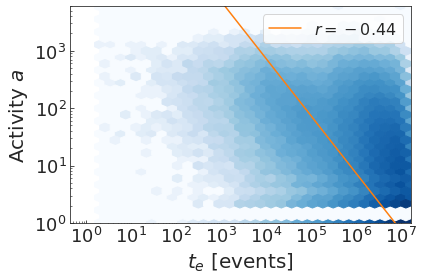

In [287]:
Activity =  np.array(DATA["Arrays"]["Act"])
EntranceFile = np.array(DATA["Arrays"]["Entr"])[Activity>0]
EntranceEvent = np.array(DATA["Arrays"]["Entr"])[Activity>0]
Activity = Activity[Activity>0]
EntranceEvent += 1.

plt.hexbin(EntranceEvent, Activity, bins='log', cmap=plt.cm.Blues, yscale="log", xscale="log", gridsize=30)
#plt.axis([T0s_ev.min(), T0s_ev.max(), Acts.min(), Acts.max()])
pears_e_vs_a = pearsonr(np.log(EntranceEvent), np.log(Activity))


Y_t0_prop_1overA = np.arange(EntranceEvent.min(), EntranceEvent.max())**-1.
Y_t0_prop_1overA /= Y_t0_prop_1overA[-1]
plt.loglog(Y_t0_prop_1overA*np.abs(pears_e_vs_a[0]),
           color="C1", label=r"$r=%.02f$" % pears_e_vs_a[0])

#plt.xscale("log")
#plt.yscale("log")

plt.ylim(Activity.min(), Activity.max())

plt.xlabel(r"$t_e$ [events]", size=20)
plt.ylabel(r"Activity $a$", size=20)

plt.xticks(size=18)
plt.yticks(size=18)


plt.legend(loc="best", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, "chi_square/entr_vs_act.pdf"), bbox_inces="tight")

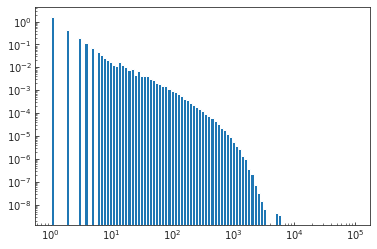

In [288]:
plt.hist(DATA["Arrays"]["Act"], bins=np.logspace(0, 5, 100), density=True)
plt.xscale("log")
plt.yscale("log")

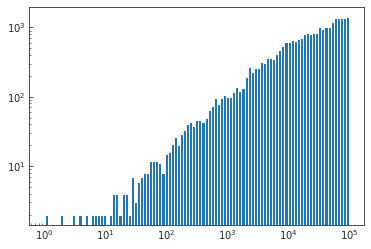

In [289]:
plt.hist(DATA["Arrays"]["Entr"], bins=np.logspace(0, 5, 100), density=False)
plt.xscale("log")
plt.yscale("log")